In [48]:
import numpy as np
import pandas as pd

df = pd.read_csv("drive/MyDrive/ECG Data - Sheet1.csv")
df.columns = ["Time (sec)", "Voltage"]
df = df.loc[1:]
df

,Time (sec),Voltage
1,0,362
2,0.005263157895,360
3,0.01052631579,357
4,0.01578947368,357
5,0.02105263158,355
...,...,...
62350,328.1526316,321
62351,328.1578947,323
62352,328.1631579,320
62353,328.1684211,321


In [49]:
DIF_SEC = float(df.loc[2]["Time (sec)"])
print(DIF_SEC)

0.005263157895


In [50]:
df["Time (sec)"] = df["Time (sec)"].apply(lambda x: float(x))
df["Voltage"] =  df["Voltage"].apply(lambda x: int(x))

We will now use the Pan-Tomkings algorithm in order to calculate the heart rate from the ECG Data.

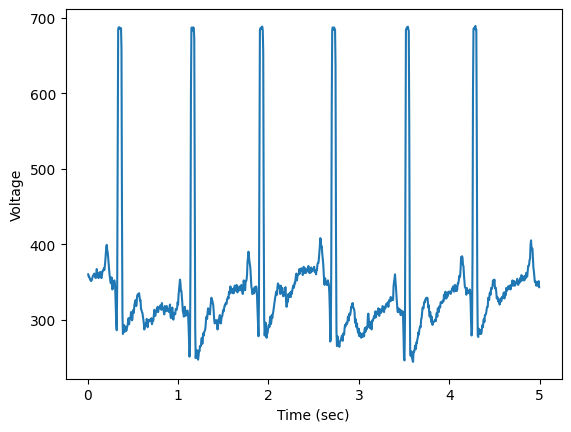

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x="Time (sec)", y="Voltage", data=df[(df["Time (sec)"] > 0) & (df["Time (sec)"] < 5)])
plt.show()

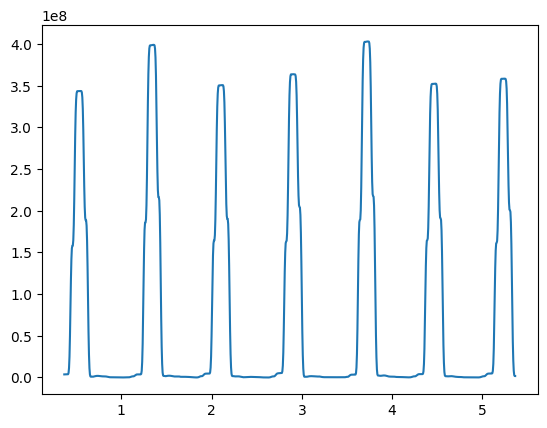

In [52]:
#x is the Voltage
def lowPass(x):
  new_y = []
  for i in range(len(x)):
    y_val = 0
    if i - 1 >= 0:
      y_val += 2*new_y[i-1]
    if i - 2 >= 0:
      y_val -= new_y[i-2]
    y_val += x[i]
    if i - 6 >= 0:
      y_val -= 2*x[i-6]
    if i - 12 >= 0:
      y_val += x[i-12]
    new_y.append(y_val)
  return new_y

def highPass(x):
  new_y = []
  for i in range(len(x)):
    y_val = 0
    if i - 16 >= 0:
      y_val += 32*x[i-16]
    if i - 1 >= 0:
      y_val -= new_y[i-1]
    y_val -= x[i]
    if i - 32 >= 0:
      y_val += x[i-32]
    new_y.append(y_val)
  return new_y

def derivative(x):
  new_y = []
  for i in range(len(x)):
    y_val = 0
    if i - 2 >= 0:
      y_val -= x[i-2]
    if i - 1 >= 0:
      y_val -= 2*x[i-1]
    if i + 1 < len(x):
      y_val += 2*x[i+1]
    if i + 2 < len(x):
      y_val += x[i+2]
    y_val = float(y_val) / 8.0
    new_y.append(y_val)
  return new_y

def square(x):
  new_y = []
  for i in range(len(x)):
    new_y.append(x[i]**2)
  return new_y

def movingInt(x):
  samp_freq = 1/DIF_SEC
  window_size = int(0.15*samp_freq)

  new_y = []
  for i in range(len(x)):
    y_val = 0
    if i - 1 >= 0:
      y_val += new_y[i-1]
    y_val += 1/window_size * x[i]
    if i - window_size >= 0:
      y_val -= 1/window_size * x[i-window_size]
    new_y.append(y_val)

  return new_y

volts_arr = np.array(df["Voltage"])
volts_result = movingInt(square(derivative(highPass(lowPass(volts_arr)))))

times = np.array(df["Time (sec)"])
#in order to skip first incorrect wave
times = times[70:]
volts_result = volts_result[70:]

sns.lineplot(x=times[:950], y=volts_result[:950])
plt.show()

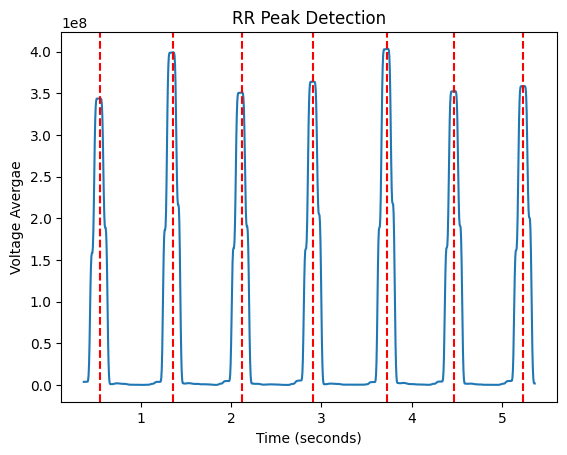

Heart Rate: 78.441208 bpm
Heart Rate Variability: 49.497754 ms


In [53]:
def getThresholds(two_sec_volts):
  signal_level = max(two_sec_volts)
  noise_level = np.mean(two_sec_volts)
  return signal_level, noise_level

def heartRate(times_, der_, volts_, signal_level, noise_level):
  RRs = []
  no_detect = int(0.2/DIF_SEC)
  i = 1
  last_detected_index = None
  time_since = 0
  while i < len(der_) - 1:
    #Check for missed QRS Complex
    if len(RRs) > 1 and time_since > 166/100*np.mean([RRs[i] - RRs[i-1] for i in range(1, len(RRs))]):
      max_peak = max(volts_[last_detected_index:i])

      for x in range(last_detected_index, i):
        if volts_[x] == max_peak:
          last_detected_index = x
          time_since = 0.2
          i += no_detect
          if times_[x] not in RRs:
            RRs.append(times_[x])
          break
      continue

    if der_[i-1] > 0 and der_[i+1] < 0:
      threshold = noise_level + 0.25*(signal_level - noise_level)
      if volts_[i] > threshold:
        #Check for incorrect T Wave
        if len(RRs) > 0 and time_since * 1000 <= 160:
          current_slope = der_[i]
          past_slope = der_[last_detected_index]
          if current_slope < past_slope / 2:
            noise_level = 0.125*volts_[i]+ 0.875*noise_level
            time_since += DIF_SEC
            i += 1
            continue

        RRs.append(times_[i])
        signal_level = 0.125*volts_[i] + 0.875*signal_level
        last_detected_index = i
        time_since = 0.2
        i += no_detect - 1
      else:
        noise_level = 0.125*volts_[i]+ 0.875*noise_level
        time_since += DIF_SEC
    else:
        time_since += DIF_SEC

    i += 1



  sns.lineplot(x=times[:950], y=volts_result[:950])
  for i in range(7):
    plt.axvline(RRs[i], linestyle='--', color='red')
  plt.xlabel("Time (seconds)")
  plt.ylabel("Voltage Avergae")
  plt.title("RR Peak Detection")
  plt.show()

  dists = [RRs[i] - RRs[i-1] for i in range(1, len(RRs))]
  heart_rate = 60/np.mean(dists)
  heart_rate_variability = np.sqrt(np.var(dists))*1000
  return heart_rate, heart_rate_variability

der_result = derivative(volts_result)
signal_level, noise_level = getThresholds(volts_result[:int(2/DIF_SEC)])
heart_rate, heart_rate_variability = heartRate(times, der_result, volts_result, signal_level, noise_level)
print(f"Heart Rate: {heart_rate:2f} bpm")
print(f"Heart Rate Variability: {heart_rate_variability:2f} ms")

In [54]:
def hr_to_conditions(hr, hrv, MOE):
  conditions = []
  if hr - MOE > 100:
    conditions.append(f"Heart Rate of f{int(hr)} ms > 100 ms could could indicate stress or pathological conditions such as hypoxia, hyperthyroidism, or cardiomyopathy")
  if hrv + MOE < 34:
    conditions.append(f"HRV of f{int(hrv)} < 34 ms could indicate stress or medical conditions such as myocardial infection, liver cirrhosis, or sepsis.")
  return conditions

print(hr_to_conditions(heart_rate, heart_rate_variability, 5))


[]


A heart rate of more than 100 bpm could indicate stress or pathological conditions such as hypoxia, hyperthyroidism, or cardiomyopathy.

A Heart Rate Variability less than 34 ms could indicate that the body is under stress, or that you have medical conditions such as myocardial infection, liver cirrhosis, or sepsis.

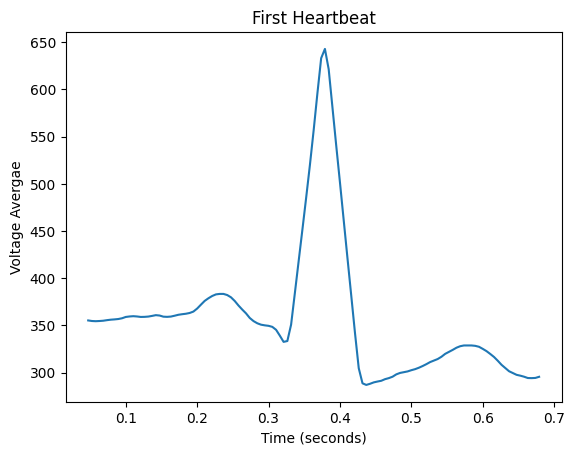

In [55]:
def movingAvg(voltages, window_size):
  return voltages.rolling(window=window_size).mean().tolist()[window_size-1:]

voltages = pd.Series(df["Voltage"])
voltage_avg = movingAvg(voltages, 10)

times = np.array(df["Time (sec)"])

start = 9
num = 130

sns.lineplot(x=times[start:num], y=voltage_avg[start-10+1:num-10+1])
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage Avergae")
plt.title("First Heartbeat")
plt.show()

We will now create functions that can detect the nearest P Wave, QRS Complex, and T Wave given the time and voltage data. We will test these functions on the first heartbeat in the data.

0.1473684211 0.2157894737 0.0684210526


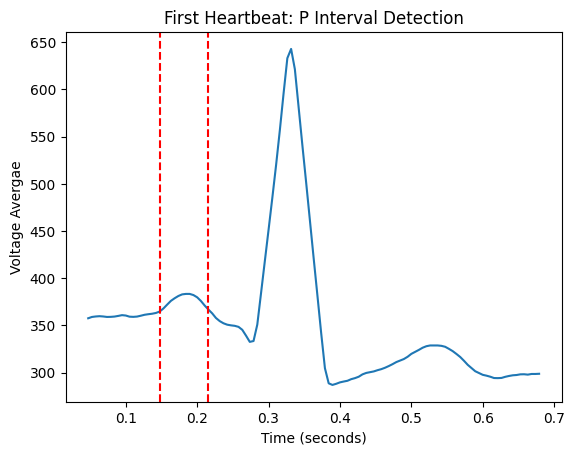

In [56]:
def PWave(x_arr, y_arr, min_sec):
  x_arr = np.array(x_arr)
  y_arr = np.array(y_arr)

  prev_x = None
  prev_y = None
  start = None
  start_val = None
  end = None
  counter = 0

  for x, y in zip(x_arr, y_arr):
    if x < min_sec:
      continue

    if prev_x is None:
      prev_x = x
      prev_y = y

    if y - prev_y > 3 and counter == 1:
      start_val = prev_y
      counter += 1
    elif counter == 1:
      counter = 0

    #3
    if y - prev_y > 2 and start_val is None and counter == 0:
      start = prev_x
      #start_val = prev_y
      counter += 1


    if start_val is not None and y <= start_val and y - prev_y <= 0:
      end = x
      break

    prev_x = x
    prev_y = y

  return start, end

start_p, end_p = PWave(times[start:num], voltage_avg[start:num], 0)
print(start_p, end_p, end_p - start_p)
sns.lineplot(x=times[start:num], y=voltage_avg[start:num])
plt.axvline(start_p, color='red', linestyle='--')
plt.axvline(end_p, color='red', linestyle='--')
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage Avergae")
plt.title("First Heartbeat: P Interval Detection")
plt.show()

A P Wave longer than 80 ms may indicate atrial enlargement

0.2684210526 0.3947368421 0.1263157895


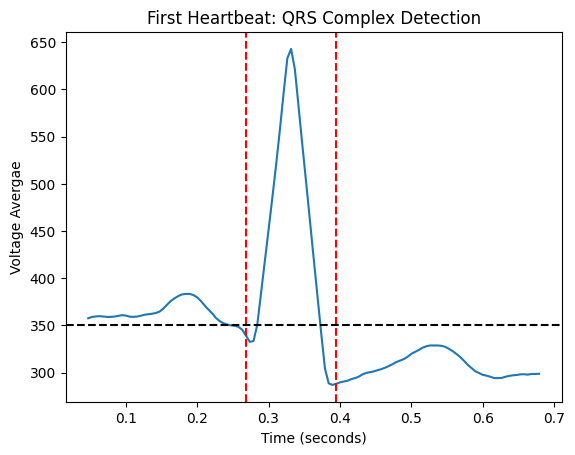

In [57]:
def QRSWave(x_arr, y_arr, min_sec):
  #Should start after the P wave

  x_arr = np.array(x_arr)
  y_arr = np.array(y_arr)

  prev_x = None
  prev_y = None
  start_r = None
  baseline = None
  end = None
  check_again = False

  for x, y in zip(x_arr, y_arr):
    if x < min_sec:
      continue

    if prev_x is None:
      prev_x = x
      prev_y = y

    if y - prev_y > 10 and baseline is None:
      start_r = prev_x
      baseline = y

    if check_again and baseline is not None and y <= baseline and y - prev_y > 0:
      end = x
      break

    if start_r is not None and baseline is not None and y <= baseline:
      check_again = True

    prev_x = x
    prev_y = y

  start_q = None
  prev_y = None

  if baseline is None:
    return None, end, None

  prev_x = None
  for x, y in zip(x_arr, y_arr):
    if x < min_sec:
      continue

    if prev_y is None:
      prev_x = x
      prev_y = y

    if prev_y - y > 3 and y <= baseline:
      start_q = prev_x
      #break

    if x >= start_r:
      break

    prev_x = x
    prev_y = y

  return start_q, end, baseline

start_q, end_qrs, baseline = QRSWave(times[start:num], voltage_avg[start:num], end_p)
print(start_q, end_qrs, end_qrs - start_q) #QRS Complex Time

sns.lineplot(x=times[start:num], y=voltage_avg[start:num])
plt.axvline(start_q, color='red', linestyle='--')
plt.axvline(end_qrs, color='red', linestyle='--')
plt.axhline(baseline, color='black', linestyle='--')
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage Avergae")
plt.title("First Heartbeat: QRS Complex Detection")
plt.show()


A QRS Complex much greater than 120 ms could indicate hyperkalemia or intraventricular conduction delay

Note: Although the S interval ends when the baseline is met after the dip, in some heartbeats like the one above the baseline is not met, so I generally defined it as after it increases after the R interval. Also, in general my S interval is not very pronounced, so this was my best estimation of the QRS interval.

In [58]:
print(start_q - start_p) #PR Interval

0.12105263149999998


A PR Interval shorter than 120 ms could be a result of the electrical impulse bypassing the AV node. A PR Interval longer than 200 ms is a first degree atrioventricular block.

0.3578947369


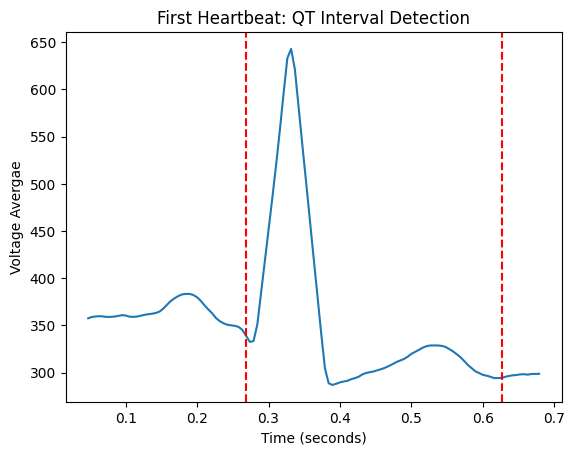

In [59]:
def TWave(x_arr, y_arr, min_sec):
  #Should start after the P wave

  x_arr = np.array(x_arr)
  y_arr = np.array(y_arr)

  prev_x = None
  prev_y = None
  end_t = None
  start_y = None
  start = None

  for x, y in zip(x_arr, y_arr):
    if x < min_sec:
      continue

    if prev_x is None:
      prev_x = x
      prev_y = y

    if y - prev_y > 1:
      start = True

    if start is not None and prev_y - y > 0.5:
      start_y = True

    if start_y is not None and y - prev_y >= 0:
      end_t = x
      break

    prev_x = x
    prev_y = y

  return end_t

end_t = TWave(times[start:num], voltage_avg[start:num], end_qrs)
print(end_t - start_q)
sns.lineplot(x=times[start:num], y=voltage_avg[start:num])
plt.axvline(start_q, color='red', linestyle='--')
plt.axvline(end_t, color='red', linestyle='--')
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage Avergae")
plt.title("First Heartbeat: QT Interval Detection")
plt.show()


A QT interval greater than 440 ms is a risk factor for ventricular tachyarrhythmias

In order to get more accurate measurements, we need to implement these functions on every heartbeat in the dataset, and then take the average lengths of each interval.

In [60]:
def all_times(times, voltage_avg, max_sec):
  current_sec = 0
  PWaves = []
  QRSWaves = []
  PRs = []
  QTs = []

  while True:
    start_p, end_p = PWave(times, voltage_avg, current_sec)
    #print(current_sec)
    try:
      PWaves.append(end_p - start_p)
    except:
      break
    current_sec = end_p


    if current_sec >= max_sec:
      break

    start_q, end_qrs, _ = QRSWave(times, voltage_avg, current_sec)
    try:
      QRSWaves.append(end_qrs-start_q)
    except:
      break
    PRs.append(start_q - start_p)

    current_sec = end_qrs

    if current_sec >= max_sec:
      break

    end_t = TWave(times, voltage_avg, current_sec)
    try:
      QTs.append(end_t - start_q)
    except:
      break


    current_sec = end_t


    if current_sec >= max_sec:
      break

  return PWaves, QRSWaves, PRs, QTs

PWaves, QRSWaves, PRs, QTs = all_times(times[start:], voltage_avg[start:], float(df.loc[df.shape[0]]["Time (sec)"]))
print(f"P Interval: {np.mean(PWaves)*1000} ms")
print(f"QRS Interval: {np.mean(QRSWaves)*1000} ms")
print(f"PR Interval: {np.mean(PRs)*1000} ms")
print(f"QT Interval: {np.mean(QTs)*1000} ms")

P Interval: 79.65893783612975 ms
QRS Interval: 121.96049634615537 ms
PR Interval: 127.43221671701424 ms
QT Interval: 343.8105759391626 ms


In [61]:
def seconds2diagnosis(PWaves, QRSWaves, PRs, QTs, MOE_ms):
  P = np.mean(PWaves)
  QRS = np.mean(QRSWaves)
  PR = np.mean(PRs)
  QT = np.mean(QTs)

  all = []
  if P*1000 - MOE_ms > 80:
    all.append(f"P Wave of {P*1000:2f} ms > 80 ms could indicate atrial enlargement")
  if QRS*1000 - MOE_ms > 120:
    all.append(f"QRS Complex of {QRS*1000:2f} ms > 120 ms could indicate hyperkalemia or intraventricular conduction delay")
  if PR*1000 + MOE_ms < 120:
    all.append(f"PR Interval of {PR*1000:2f} ms < 120 ms could indicate that the electrical impulse is bypassing the AV node")
  if PR*1000 - MOE_ms > 200:
    all.append(f"PR Interval of {PR*1000:2f} ms > 200 ms could indicate first degree atrioventricular block")
  if QT*1000 - MOE_ms > 440:
    all.append(f"QT Interval of {QT*1000:2f} ms > 440 ms could indicate ventricular tachyarrhythmias")

  return all

print(seconds2diagnosis(PWaves, QRSWaves, PRs, QTs, 5))

[]
